* To investigate the forcings on stratification and total currents. 

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytz 
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'j' : 46,
        'i' : 53   
    },
    'VENUS East':{
        'lat': 49.0419,
        'lon': -123.3176,
        'depth': 170, 
        'j': 36,##should be 416,
        'i': 43,##should be 283
    },    
    'VENUS Central':{
        'lat': 49.0401,
        'lon': -123.4261,
        'depth': 300,
        'j': 44,##should be 424,
        'i': 26,##should be 266
    },
    }

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* Load model result

* Only river

In [4]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No tides

In [5]:
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No winds

In [6]:
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')

* No f

In [7]:
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')

 * Combine all forcings

In [8]:
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [9]:
def plot_stratification_current(stn, dep_ind,ty,grid_T,grid_U,grid_V,time_ind,\
                                cmin = 0,cmax = 33,vmin = -0.5,vmax = 0.5):
    """This function is made to plot the 
    stratification and horizontal current of a specific station """
    S = grid_T.variables['vosaline']
    t = grid_T.variables['time_counter']
    dep_T = grid_T.variables['deptht']
    U = grid_U.variables['vozocrtx']
    dep_U = grid_U.variables['depthu']
    V = grid_V.variables['vomecrty']
    dep_V = grid_V.variables['depthv']
    S_stn = S[:,:,sites[stn]['j'],sites[stn]['i']]
    time_inds = np.arange(S.shape[0]) ## Define time
    fig, axs = plt.subplots(1,3,figsize = (22,4))
    ## stratification
    ax = axs[0]
    mesh = ax.contourf(time_inds, dep_T[:],np.transpose(S_stn[:]),np.arange(cmin, cmax+3, 3),cmap = 'jet')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('Practical Salinity')
    ax.set_title(ty+' stratification of '+stn)
    ## U current
    ax = axs[1]
    UU,VV = viz_tools.unstagger(U[:,:,sites[stn]['j']:sites[stn]['j']+2,sites[stn]['i']:sites[stn]['i']+2],\
                                V[:,:,sites[stn]['j']:sites[stn]['j']+2,sites[stn]['i']:sites[stn]['i']+2])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)

    mesh = ax.contourf(time_inds, dep_U[:],np.transpose(UU[:,:,0,0]),np.arange(vmin, vmax+0.03, 0.03),cmap = 'cool')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('U Velocity [m/s]')
    ax.set_title(ty+' U velocity of '+stn)
    ## V current
    ax = axs[2]
    mesh = ax.contourf(time_inds, dep_V[:],np.transpose(VV[:,:,0,0]),np.arange(vmin, vmax+0.03, 0.03),cmap = 'cool')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('V Velocity [m/s]')
    ax.set_title(ty+' V velocity of '+stn)
    
    for ax, dep in zip(axs,[dep_T,dep_U,dep_V]):
        ax.set_ylim([dep[dep_ind], dep[0]])
        ax.set_xlim(time_inds[time_ind],time_inds[-1])
        ax.set_xlabel('Time [hr]')
        ax.set_ylabel('Depth [m]')
    return fig

# Stratification and horizontal currents

* Sandheads

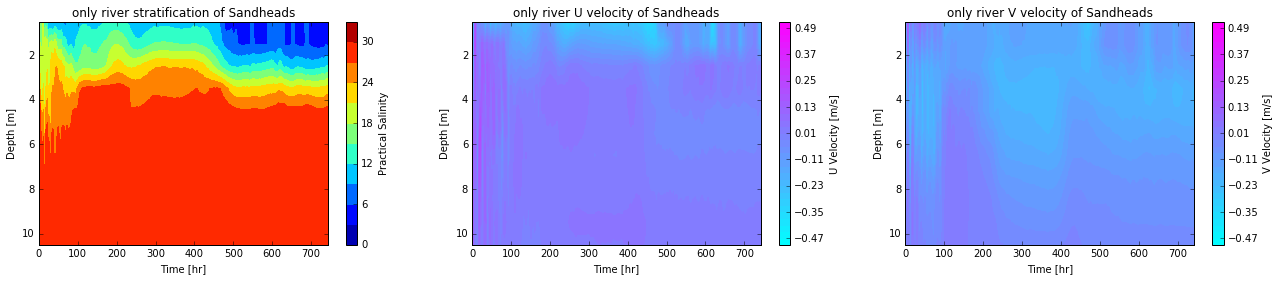

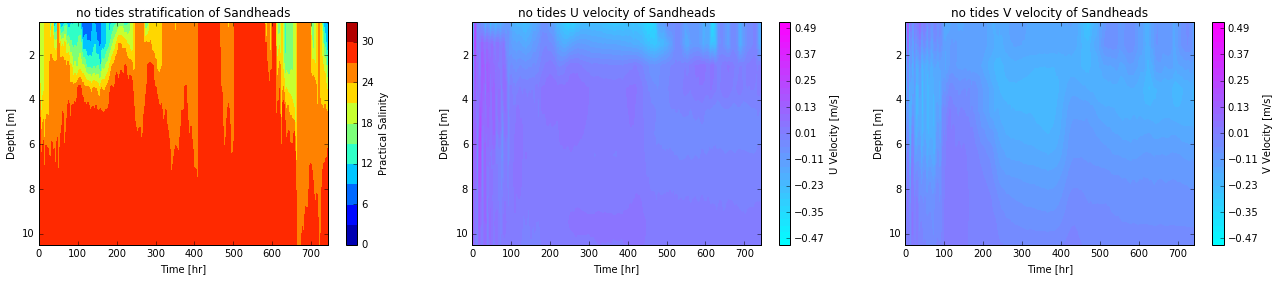

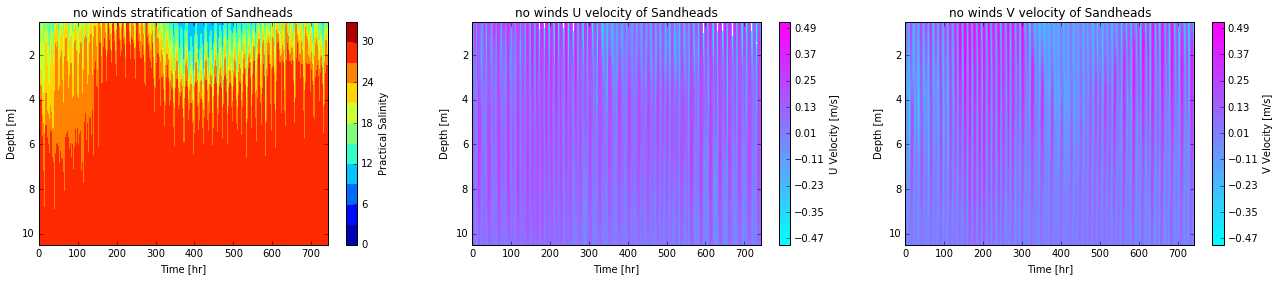

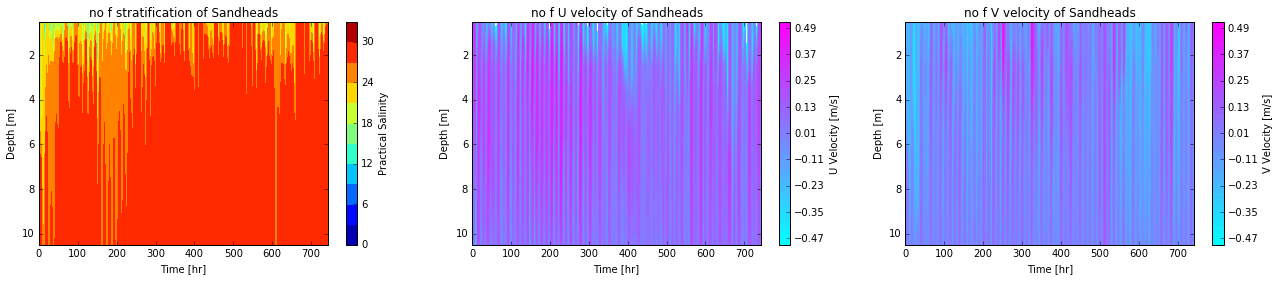

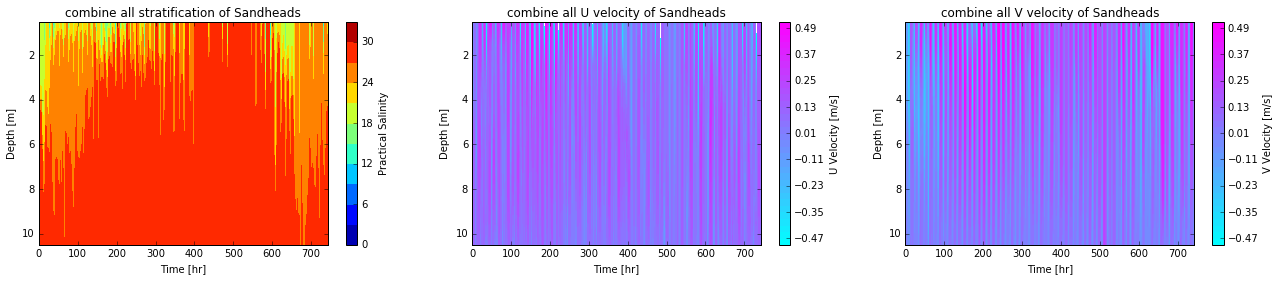

In [10]:
fig = plot_stratification_current('Sandheads',10,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('Sandheads',10,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('Sandheads',10,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('Sandheads',10,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('Sandheads',10,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

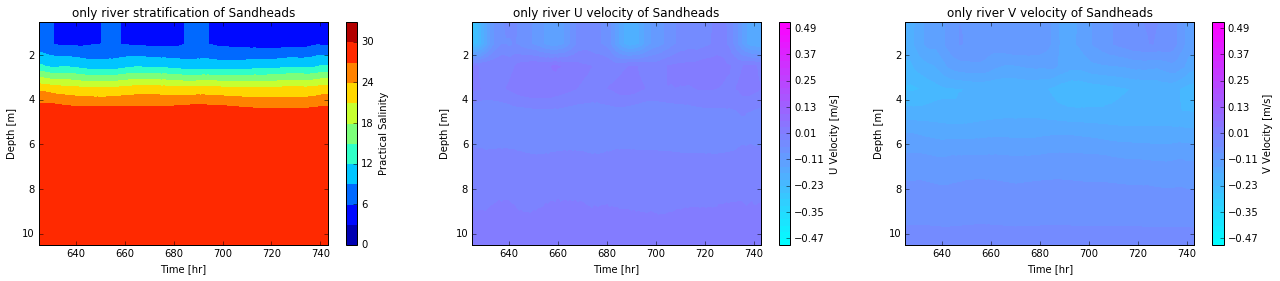

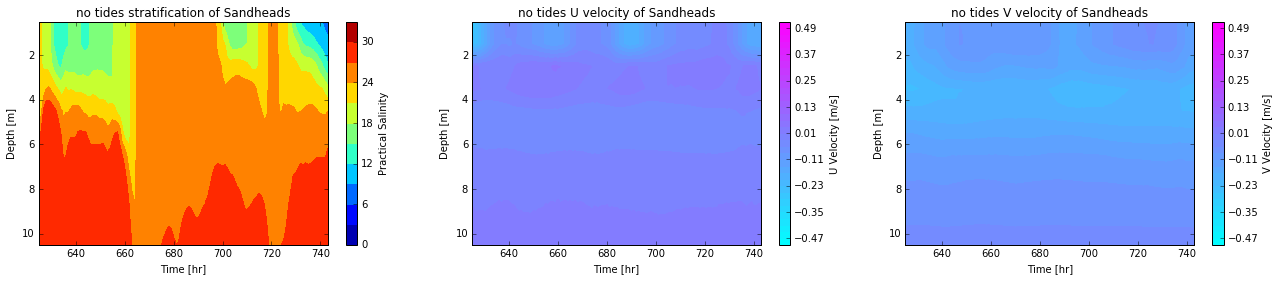

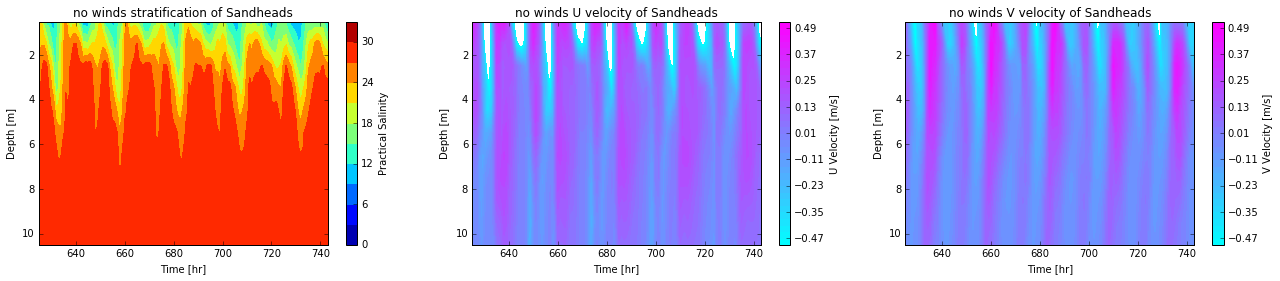

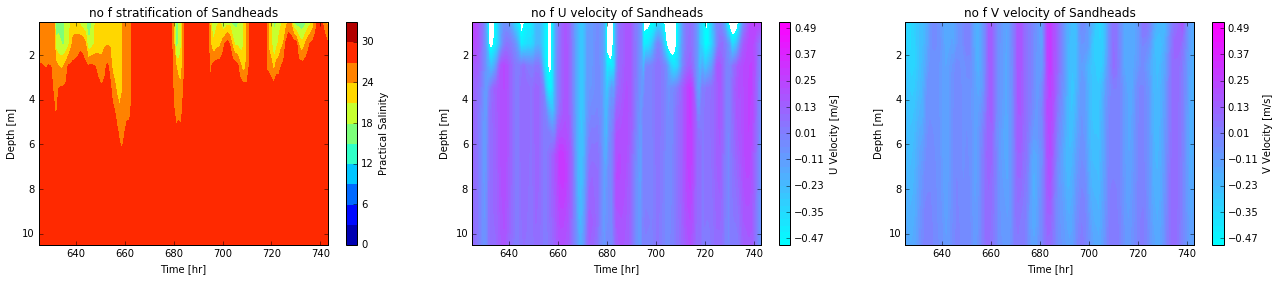

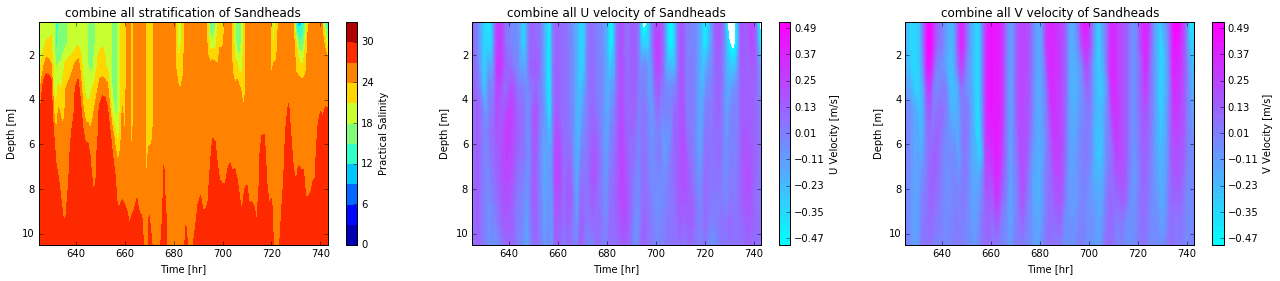

In [11]:
fig = plot_stratification_current('Sandheads',10,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('Sandheads',10,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('Sandheads',10,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('Sandheads',10,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('Sandheads',10,'combine all',all_T,all_U,all_V,625)

* VENUS Central

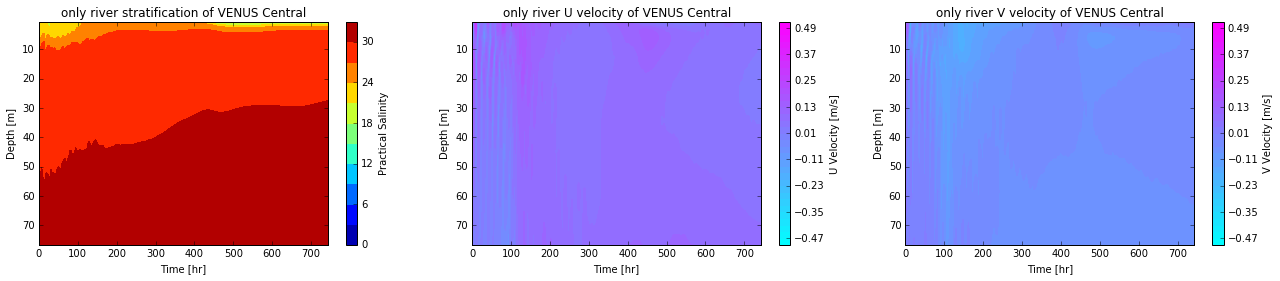

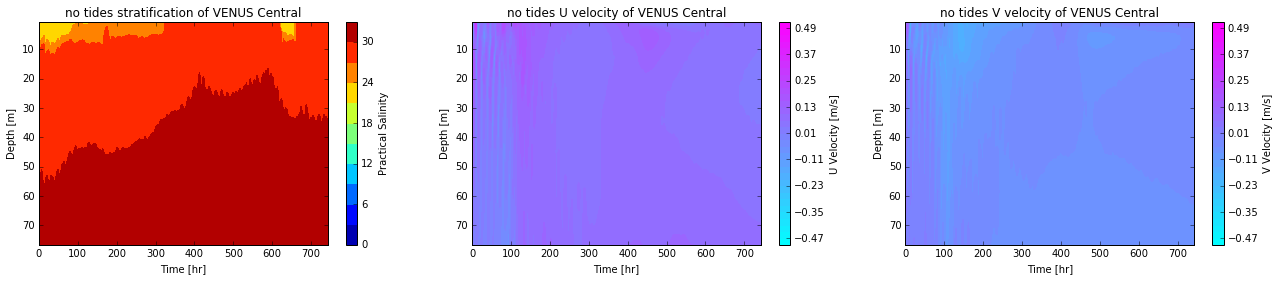

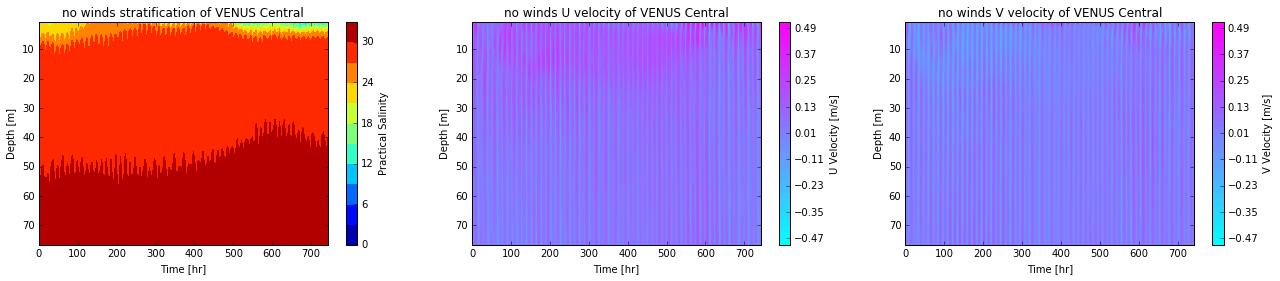

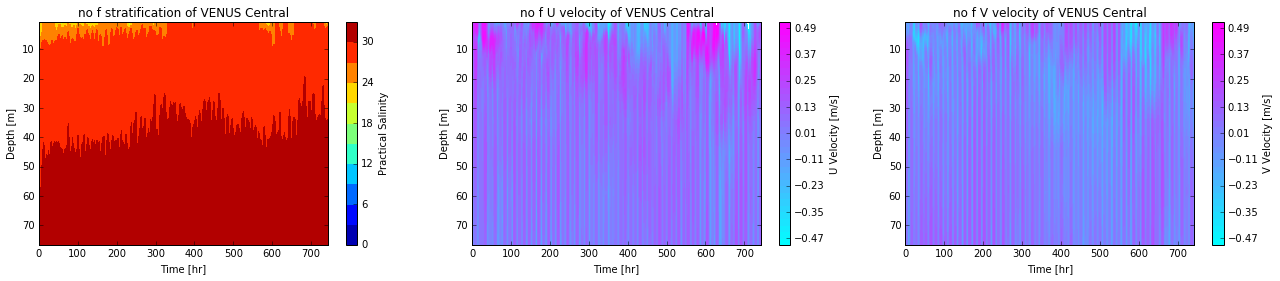

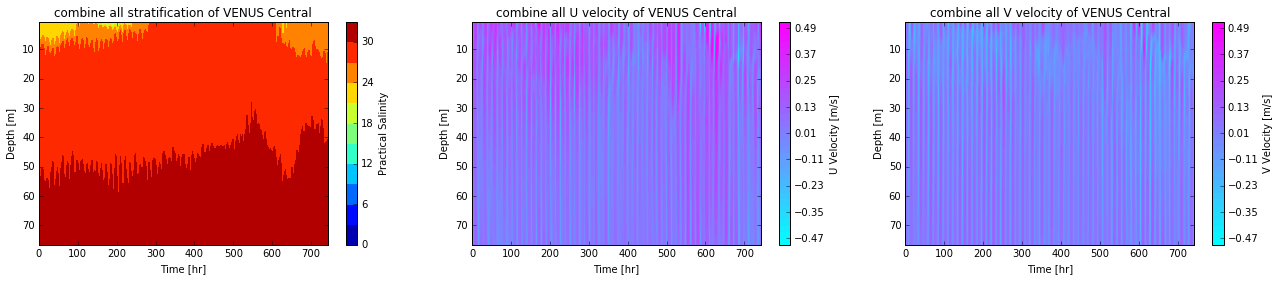

In [12]:
fig = plot_stratification_current('VENUS Central',25,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('VENUS Central',25,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('VENUS Central',25,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('VENUS Central',25,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('VENUS Central',25,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

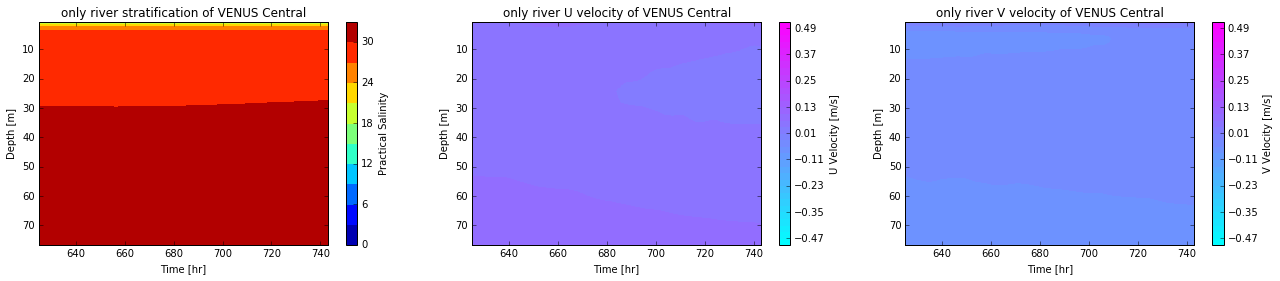

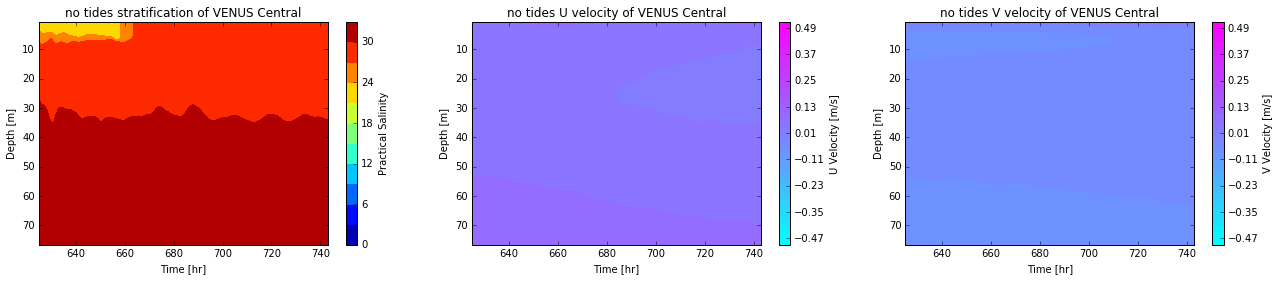

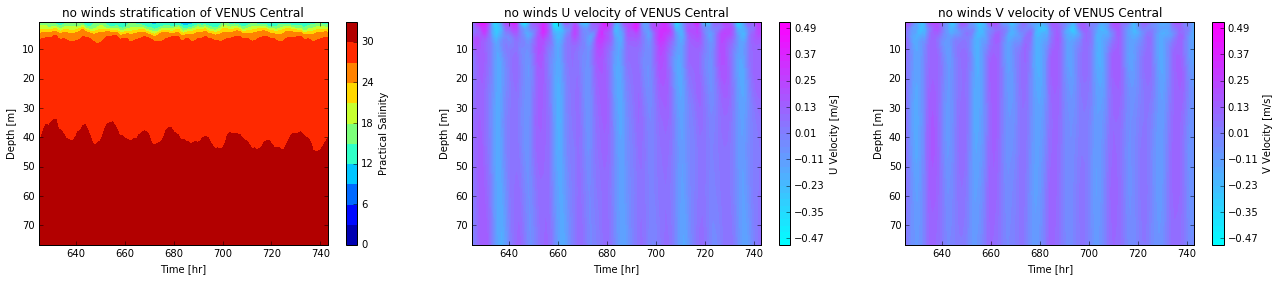

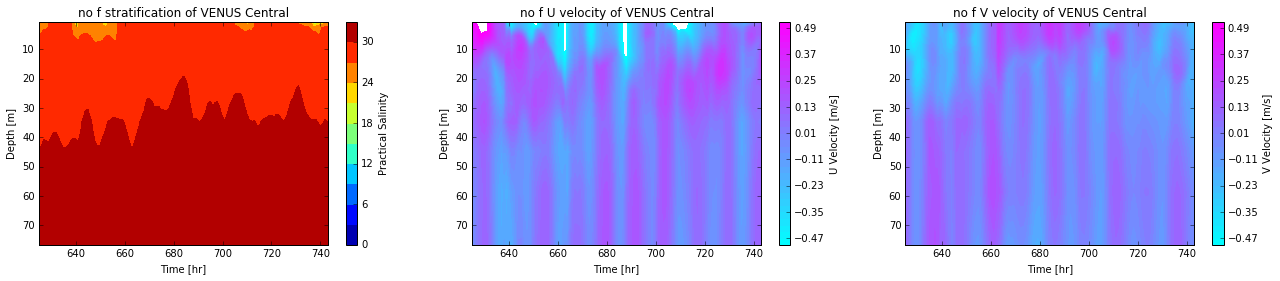

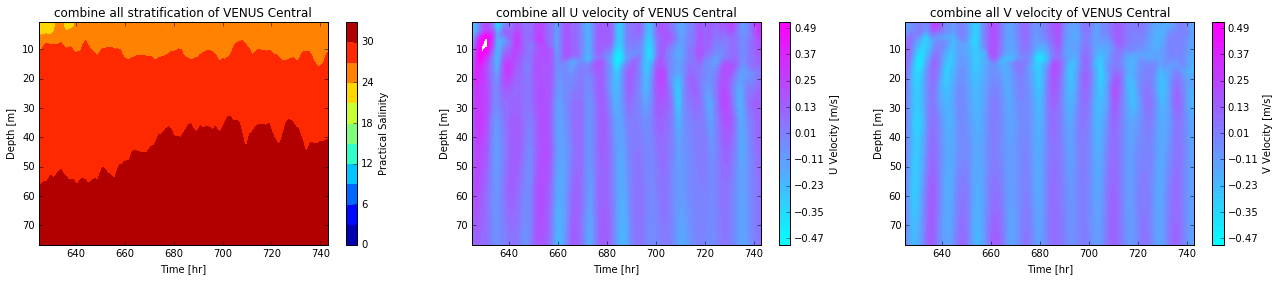

In [13]:
fig = plot_stratification_current('VENUS Central',25,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('VENUS Central',25,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('VENUS Central',25,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('VENUS Central',25,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('VENUS Central',25,'combine all',all_T,all_U,all_V,625)

* VENUS East

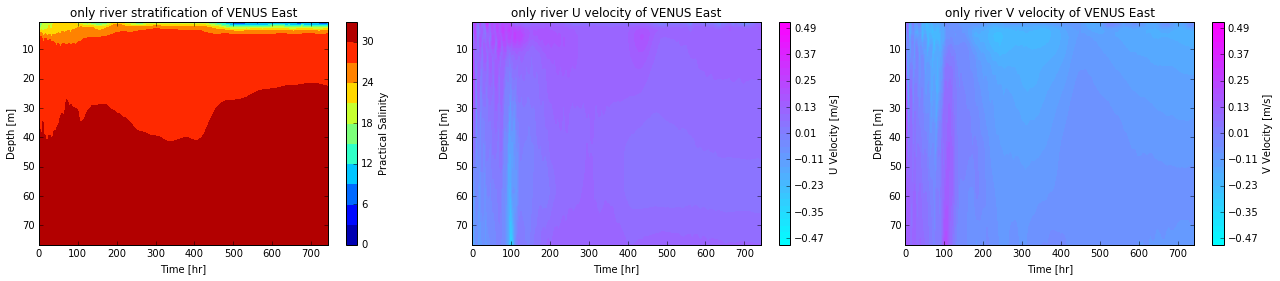

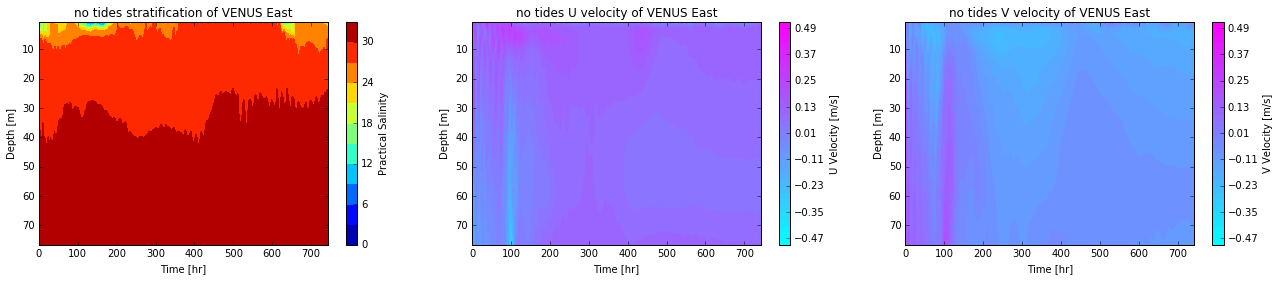

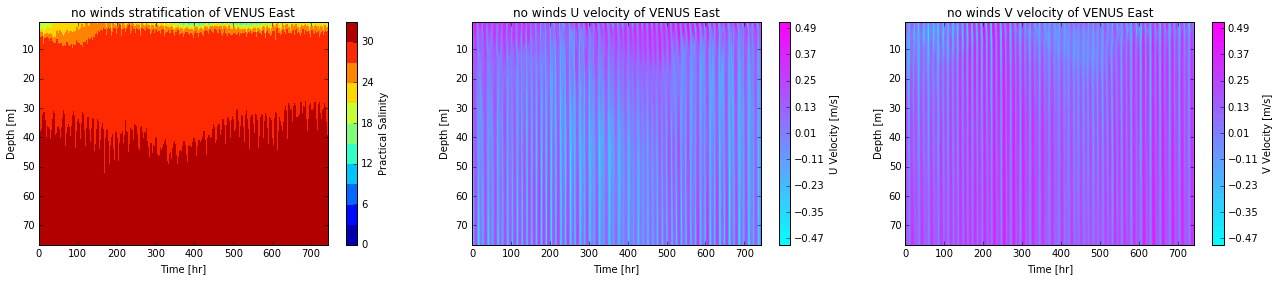

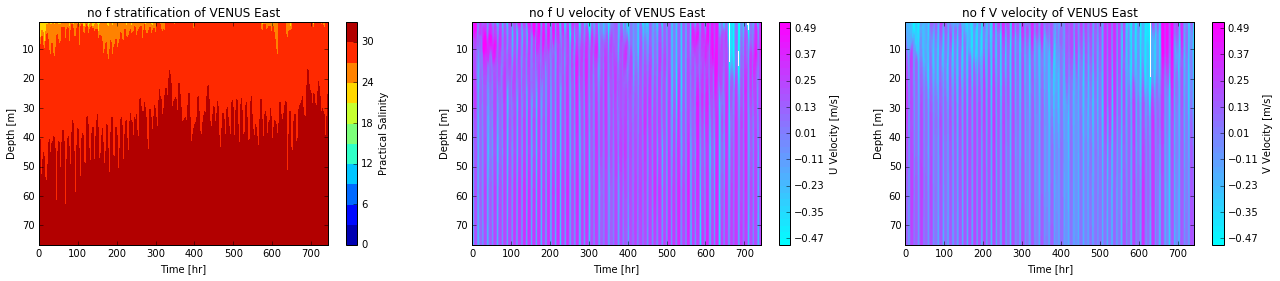

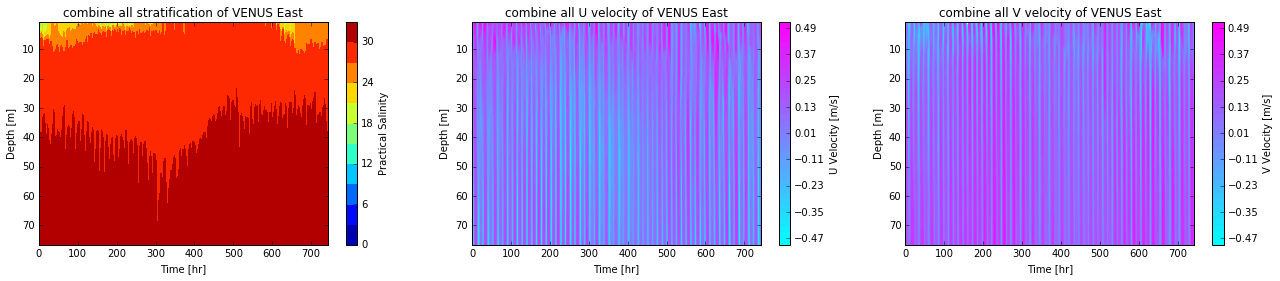

In [14]:
fig = plot_stratification_current('VENUS East',25,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('VENUS East',25,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('VENUS East',25,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('VENUS East',25,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('VENUS East',25,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

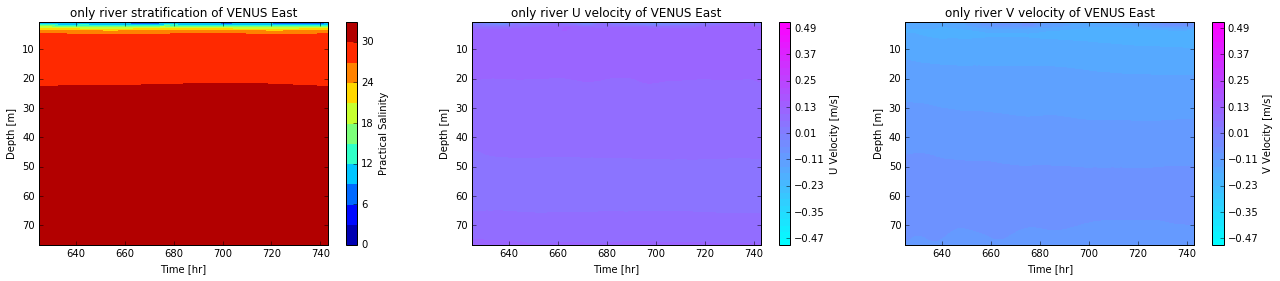

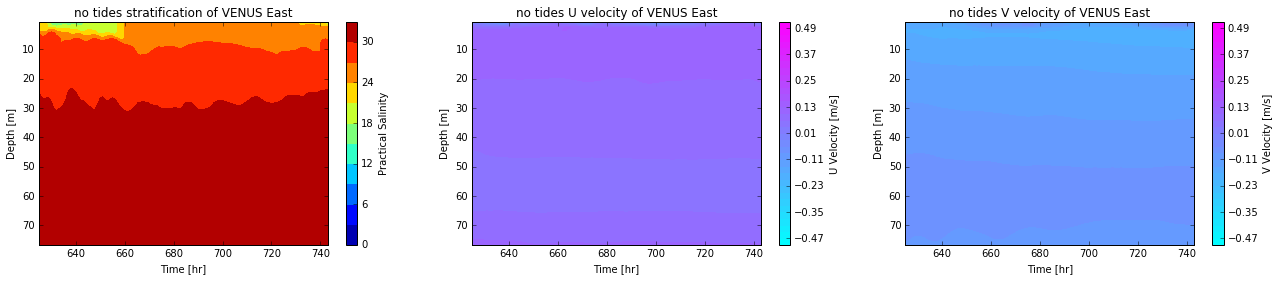

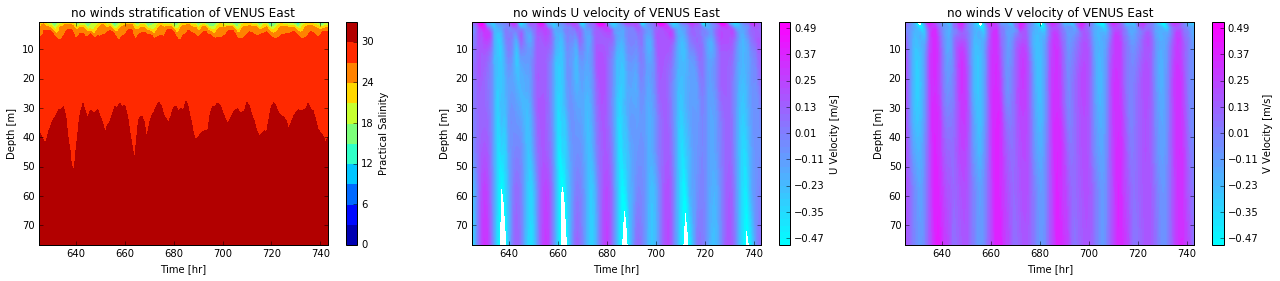

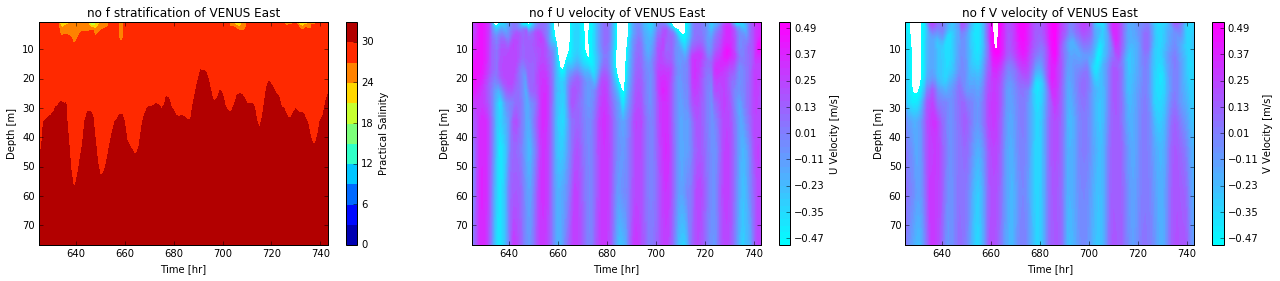

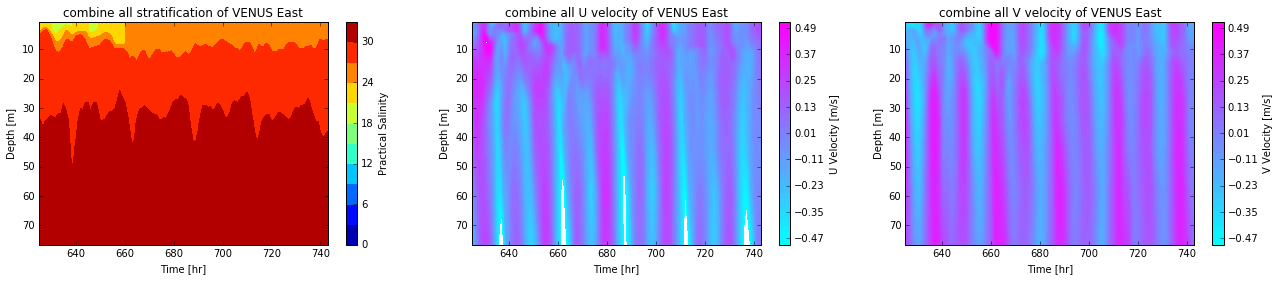

In [15]:
fig = plot_stratification_current('VENUS East',25,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('VENUS East',25,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('VENUS East',25,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('VENUS East',25,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('VENUS East',25,'combine all',all_T,all_U,all_V,625)

# In the estuary

In [16]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/\
tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

In [17]:
def find_ind_tide(run_low, run_up, run_label):
    """To find index of ttide within a time range"""
    run_low = run_low.replace(tzinfo=pytz.utc) ## convert model datetime to tzinfo=<UTC>
    run_up = run_up.replace(tzinfo=pytz.utc) ## the time i want to label on the plot
    run_label = run_label.replace(tzinfo=pytz.utc)
    ttide_dt  = ttide.time.dt.to_pydatetime() ## convert ttide.time (pandas) to datetime
    for i in range(len(ttide_dt)):
        if ttide_dt[i]== run_low:
            low_ind = i
        if ttide_dt[i]== run_up:
            up_ind = i  
        if ttide_dt[i]== run_label:
            lab_ind = i  
    return low_ind, up_ind, lab_ind

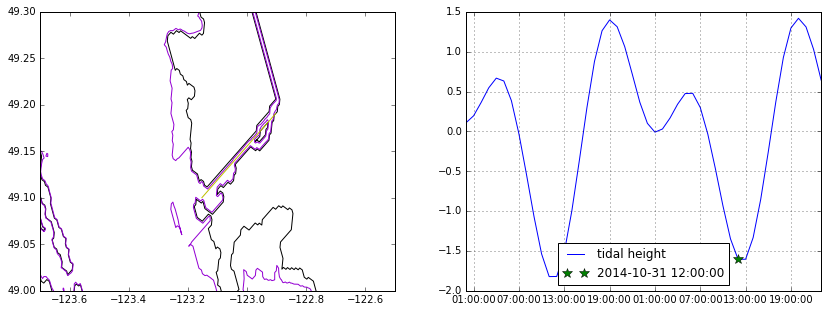

In [18]:
fig, axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,74:123],lat[36,74:123],'y-') ## transect
ax.set_xlim([-123.7,-122.5])
ax.set_ylim([49.,49.3])
ax = axs[1]
run_low = datetime.datetime(2014,10,30)
run_up = datetime.datetime(2014,11,1)
run_label = datetime.datetime(2014,10,31,12)
low_ind,up_ind,lab_ind = find_ind_tide(run_low,run_up,run_label)
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind],label = 'tidal height')
ax.plot(ttide.time[lab_ind],ttide.pred_all[lab_ind],'g*',markersize = 10,label = run_label)
ax.legend(loc = 'best')
ax.grid('on')

In [19]:
def plot_salinity_estuary(grid_T,dep_ind,grid_T2 = None,string ='tides',smin = 0, smax = 30):
    """This function was made to plot salinity along the transect in 
    different forcing cases"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    dep = grid_T.variables['deptht']
    fig,axs = plt.subplots(1,2,figsize = (14,6))
    ax = axs[0]
    if string =='tides':
        mesh = ax.contourf(lon[36,74:123], dep[:], S[-4,:,36,74:123],np.arange(smin,smax+3,3),cmap = 'jet')
        ax.set_title('flood tides')
    else:
        mesh =ax.contourf(lon[36,74:123], dep[:], S[-1,:,36,74:123],np.arange(smin,smax+3,3),cmap = 'jet')
        ax.set_title('normal winds')
    ax = axs[1]
    if string =='tides':
        mesh =ax.contourf(lon[36,74:123], dep[:], S[-11,:,36,74:123],np.arange(smin,smax+3,3),cmap = 'jet')
        ax.set_title('ebb tides')
    else:
        S2 = grid_T2.variables['vosaline']
        mesh =ax.contourf(lon[36,74:123], dep[:], S2[-1,:,36,74:123],np.arange(smin,smax+3,3),cmap = 'jet')
        ax.set_title('no winds')
    for ax in axs:
        cbar=fig.colorbar(mesh,ax = ax)
        cbar.set_label('Practical Salinity')
        ax.set_xlabel('Lon')
        ax.set_ylabel('Depth [m]')
        ax.set_xlim([lon[36,74],lon[36,123]])
        ax.set_ylim([dep[dep_ind],dep[0]])
    return fig

* No winds case, to look at the salinity in response with flood/ebb tides during a steady river flow.

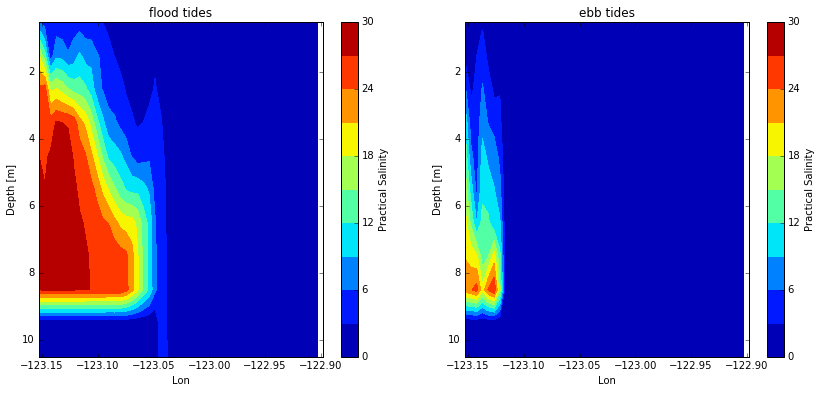

In [20]:
fig = plot_salinity_estuary(nowind_T,10)

* No tides case, to look at the salinity at final time in response with high wind, normal wind and no wind with a almost constant river flow.

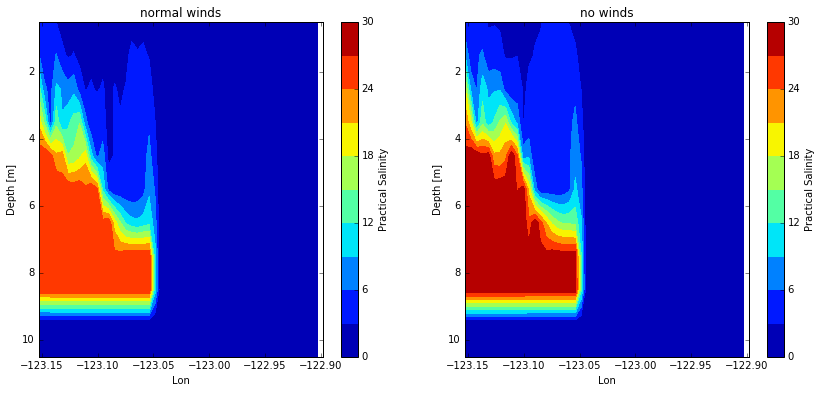

In [21]:
fig = plot_salinity_estuary(notide_T,10,river_T,'winds')

# Final circulation pattern

In [10]:
def plot_spatial_circulation(grid_T,grid_U,grid_V,dep_ind,string,smin = 0,smax = 30,st=3):
    """This function was made to plot the circulation pattern of each case of 
    the final time"""
    fig, ax= plt.subplots(1,1,figsize=(6,6))
    S = grid_T.variables['vosaline'][-1,dep_ind,:,:]
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    U = grid_U.variables['vozocrtx']
    V = grid_V.variables['vomecrty']
    UU,VV = viz_tools.unstagger(U[-1,dep_ind,:,:],V[-1,dep_ind,:,:])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)
    mesh=ax.pcolormesh(lon,lat,S[:],cmap='spectral')
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('Practical Salinity')
    mesh.set_clim(vmin=smin, vmax=smax)
    #quivers
    lon = grid_T.variables['nav_lon'][:-1,:-1]
    lat = grid_T.variables['nav_lat'][:-1,:-1]
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st], UU[::st,::st], VV[::st,::st],
                pivot='mid', width=0.003,scale=5, color='black',headwidth=2,headlength=2)
    ax.quiverkey(quiver,-123.1,49.2, 0.5, '0.5 m/s',
                 coordinates='data', color='black', labelcolor='black')
    #land
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.set_xlim([-123.75,-122.8])
    ax.set_ylim([48.85,49.4])
    ax.set_title(string)
    return fig

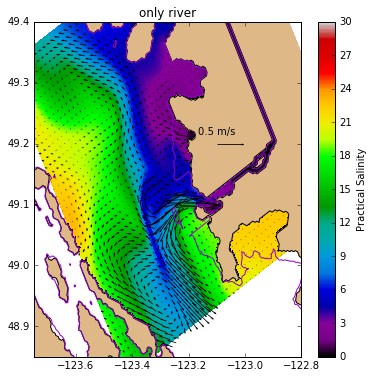

In [38]:
fig = plot_spatial_circulation(river_T,river_U,river_V,0,'only river')

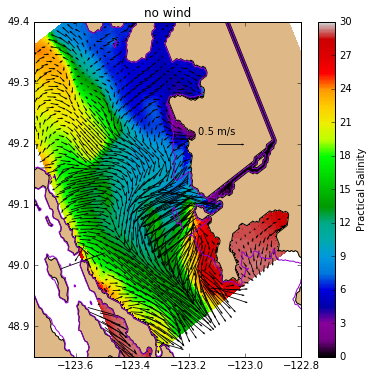

In [11]:
fig = plot_spatial_circulation(nowind_T,nowind_U,nowind_V,0,'no wind')

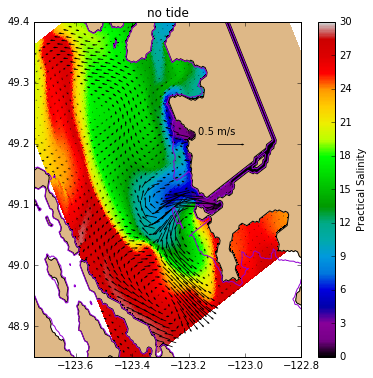

In [12]:
fig = plot_spatial_circulation(notide_T,notide_U,notide_V,0,'no tide')

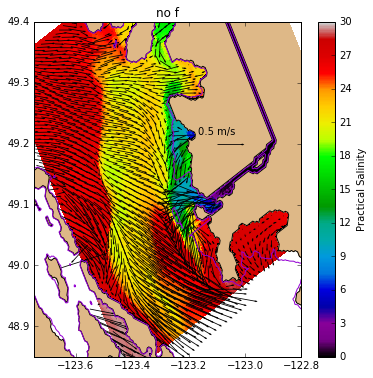

In [13]:
fig = plot_spatial_circulation(nof_T,nof_U,nof_V,0,'no f')

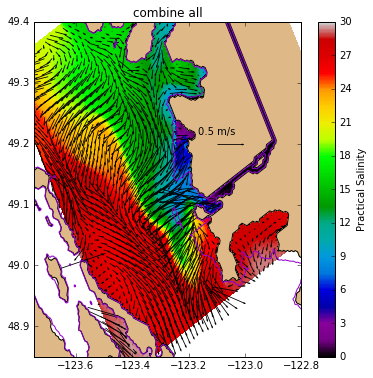

In [14]:
fig = plot_spatial_circulation(all_T,all_U,all_V,0,'combine all')